# 03 - Data Preparation - Features Creation
* (1) Create feature file in a DataFrame and CSV formats
    * Here I will only show a simple version of features file, that includes:
    * Row: subject_id, activity, event_num, walk_or_not, unique_id, time_s, la_x, la_y, la_z, fea_1, fea_2, ..., fea_1_norm, fea_2_norm, fea_3_norm, ... 
      - For Activity, it will include the following activity as True Positive and True Negative events:
        - True Positive (Walking): 1=walking; 2=descending stairs; 3=ascending stairs; 
        - True Negative (Non-Walking): 4=driving; 77=clapping; 99=non-study activity
    * The default data length for eash event will be 10-sec

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils
from constants import Constants

In [2]:
'''
* (1) Load functions and default setting variables by using *utils.py* and *constants.py* files
'''
# Get a list of all accelerometer files
all_files = utils.get_all_files()

# Setup paramters
fs = Constants.fs

In [60]:
'''
(1) Create feature file in a DataFrame and CSV formats
'''
# Load one accelerometer data file into dataframe
load_id = 0     # Load the first CSV file from the file list 
file_id, df = utils.load_single_data(all_files, load_id)

# General setting
location_id = 'la'
win_length = 6  # default will be 10-sec for each event
win_shift = 3  # No overlapping between each event 
acc_inputs = ['la_x', 'la_y', 'la_z']   # Only select Left-Ankle for now
activities = [1, 2, 3, 4, 77, 99]       # All 6 activities with annotations
activities_TP = [1, 2, 3]               # 1=walking; 2=descending stairs; 3=ascending stairs;
activities_TN = [4, 77, 99]             # 4=driving; 77=clapping; 99=non-study activity;

# Create an empty dataframe with defaulted column names 
columns_features = ['subject_id', 'activity', 'event_num', 'walk_or_not', 'unique_id', 'time_s', 'la_x', 'la_y', 'la_z']
df_fea_all = pd.DataFrame(columns=columns_features)

for activity in activities:
    # create a temporal dataframe 
    df_fea_layer_1 = pd.DataFrame(columns=columns_features)
    
    df_act = df[df.activity==activity]

    # Begin to cut data into several 10-sec events
    total_segments_sec = round( (df_act.time_s.iloc[-1]-df_act.time_s.iloc[0]) / ( win_length-(win_length-win_shift) ) )  # compute how many segmnets in second will be cut
    for count, num in enumerate(range(0, total_segments_sec), start=1):
        df_fea_layer_2 = pd.DataFrame(columns=columns_features)
        
        cut_begin = df_act.time_s.iloc[0] + num*win_length
        cut_end   = cut_begin + win_length 
        df_cut_tmp = df_act[(df_act.time_s>=cut_begin) & (df_act.time_s<=cut_end)]
        
        # Write values into a temporal feature dataframe
        if df_cut_tmp.empty:
            df_fea_layer_2 = pd.DataFrame(columns=columns_features)  # If no values within the cut datafrmae
        else:
            if (df_cut_tmp.time_s.iloc[-1]-df_cut_tmp.time_s.iloc[0]) < win_length*0.9: 
                # apply quality control to make sure the segment does not include missing data
                # If the segment length is less than 90% of the target time window (9 sec in this case), discard this segment. 
                df_fea_layer_2 = pd.DataFrame(columns=columns_features)
            else:
                # Write the cut dataframe into a temporal feature dataframe
                df_fea_layer_2['time_s'] = df_cut_tmp['time_s']
                df_fea_layer_2['la_x'] = df_cut_tmp['la_x']
                df_fea_layer_2['la_y'] = df_cut_tmp['la_y']
                df_fea_layer_2['la_z'] = df_cut_tmp['la_z']
        
                # Write others values into the temporal feature dataframe 
                df_fea_layer_2['subject_id'] = file_id.split('/')[-1].split('.')[0]
                df_fea_layer_2['activity'] = activity
                df_fea_layer_2['event_num'] = count
                if activity in activities_TP:
                    df_fea_layer_2['walk_or_not'] = 1
                    df_fea_layer_2['unique_id'] = file_id.split('/')[-1].split('.')[0] + '_' + str(activity) + '_' + str(count) + '_1'
                elif activity in activities_TN:
                    df_fea_layer_2['walk_or_not'] = 0
                    df_fea_layer_2['unique_id'] = file_id.split('/')[-1].split('.')[0] + '_' + str(activity) + '_' + str(count) + '_0'
                
        # Reset dataframe index
        df_fea_layer_2 = df_fea_layer_2.reset_index(drop=True)

        # Concat each 10-sec dataframe into a larger dataframe
        df_fea_layer_1 = pd.concat([df_fea_layer_1, df_fea_layer_2])
        df_fea_layer_1 = df_fea_layer_1.reset_index(drop=True)
        
    # Concat all dataframes into one big final dataframe
    df_fea_all = pd.concat([df_fea_all, df_fea_layer_1])
    df_fea_all = df_fea_all.reset_index(drop=True)    

# # Save the output dataframe to a parquet format (to save up to 90% of space)
df_fea_all.to_parquet('../outputs/df_fea_la.parquet')
df_fea_all.to_csv('../outputs/df_fea_la.csv')

In [78]:
df = pd.read_parquet('../outputs/df_fea_la.parquet')

np.unique(df.unique_id)

array(['idf1ce9a0f_1_107_1', 'idf1ce9a0f_1_108_1', 'idf1ce9a0f_1_109_1',
       'idf1ce9a0f_1_110_1', 'idf1ce9a0f_1_111_1', 'idf1ce9a0f_1_112_1',
       'idf1ce9a0f_1_113_1', 'idf1ce9a0f_1_114_1', 'idf1ce9a0f_1_115_1',
       'idf1ce9a0f_1_15_1', 'idf1ce9a0f_1_16_1', 'idf1ce9a0f_1_17_1',
       'idf1ce9a0f_1_18_1', 'idf1ce9a0f_1_19_1', 'idf1ce9a0f_1_1_1',
       'idf1ce9a0f_1_20_1', 'idf1ce9a0f_1_21_1', 'idf1ce9a0f_1_22_1',
       'idf1ce9a0f_1_23_1', 'idf1ce9a0f_1_24_1', 'idf1ce9a0f_1_25_1',
       'idf1ce9a0f_1_26_1', 'idf1ce9a0f_1_27_1', 'idf1ce9a0f_1_28_1',
       'idf1ce9a0f_1_29_1', 'idf1ce9a0f_1_2_1', 'idf1ce9a0f_1_30_1',
       'idf1ce9a0f_1_31_1', 'idf1ce9a0f_1_32_1', 'idf1ce9a0f_1_33_1',
       'idf1ce9a0f_1_34_1', 'idf1ce9a0f_1_35_1', 'idf1ce9a0f_1_36_1',
       'idf1ce9a0f_1_37_1', 'idf1ce9a0f_1_3_1', 'idf1ce9a0f_1_46_1',
       'idf1ce9a0f_1_47_1', 'idf1ce9a0f_1_48_1', 'idf1ce9a0f_1_49_1',
       'idf1ce9a0f_1_4_1', 'idf1ce9a0f_1_50_1', 'idf1ce9a0f_1_51_1',
       'idf1ce9

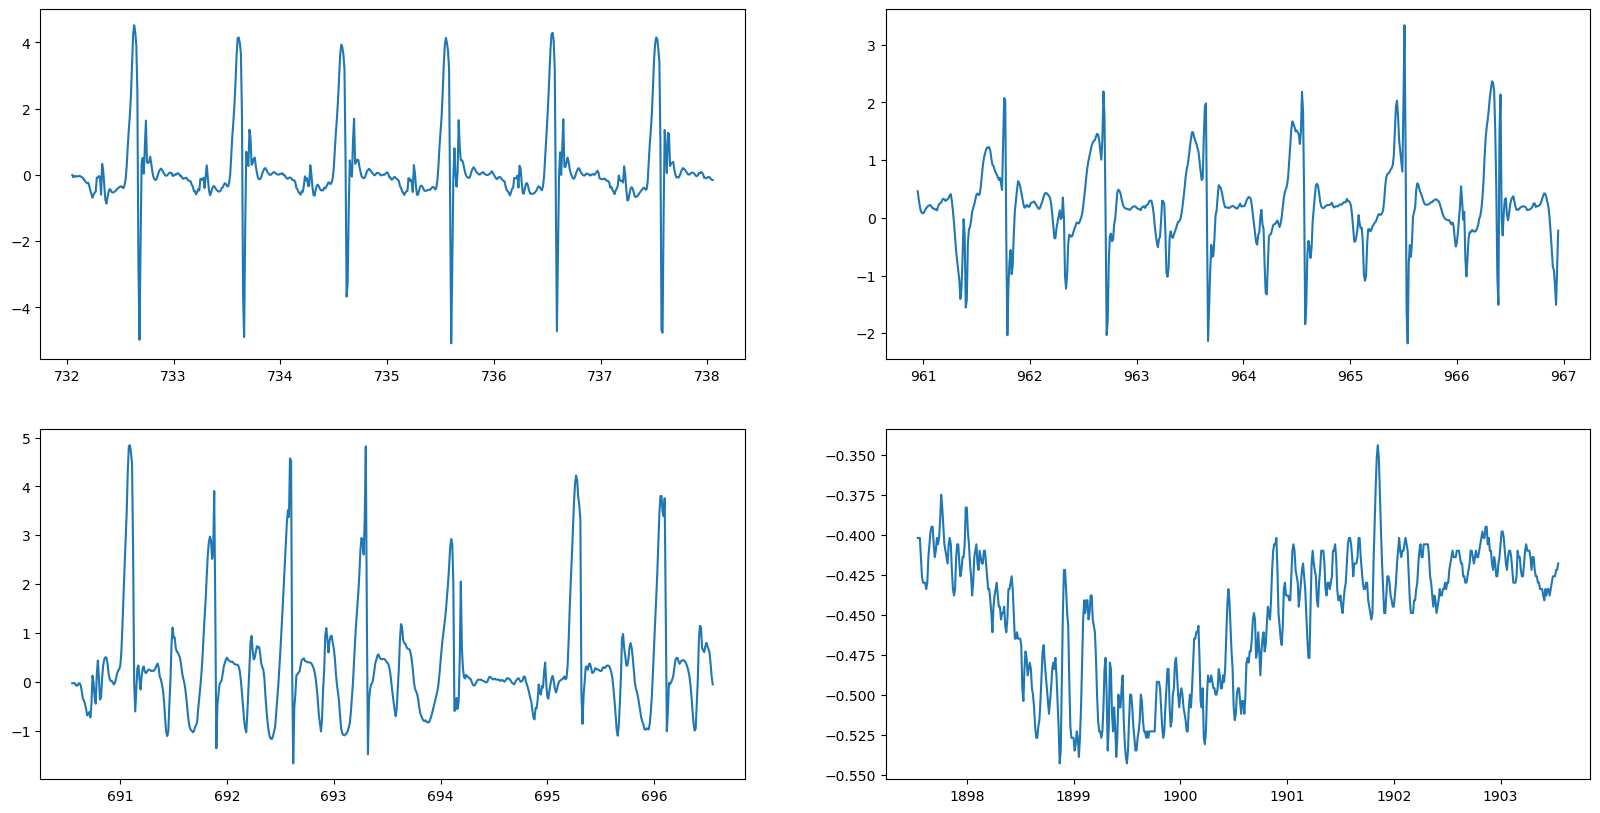

In [81]:
fig = plt.figure(figsize=(20, 10))

plt.subplot(2,2,1)
df2 = df[(df.unique_id=='idf1ce9a0f_1_64_1')]
plt.plot(df2.time_s, df2.la_x)

plt.subplot(2,2,2)
df2 = df[(df.unique_id=='idf1ce9a0f_2_95_1')]
plt.plot(df2.time_s, df2.la_x)

plt.subplot(2,2,3)
df2 = df[(df.unique_id=='idf1ce9a0f_3_48_1')]
plt.plot(df2.time_s, df2.la_x)

plt.subplot(2,2,4)
df2 = df[(df.unique_id=='idf1ce9a0f_4_87_0')]
plt.plot(df2.time_s, df2.la_x)